# P, PI control of water turbine

Assume we will work with the following model
$$
\begin{equation}
\mu(s) = \frac{1-T_Ws}{(1+0.5T_Ws)(1+T_{s}s)} \frac{K_r}{K_m} \psi(s),
\end{equation}
$$
where $\mu$ is power output, $\psi$ is input and the rest are parameters defined in code.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.signal import tf2ss


In [2]:
Tw = 0.5  # Time constant T_w
Ts = 0.1  # Time constant T_s
Kr = 0.55  # Gain K_r
Km = 1.0  # Gain K_m

# Transfer function coefficients
numerator_coeffs = [Kr * -Tw, Kr]  # Numerator (1 - T_w s) K_r
denominator_coeffs = [0.5 * Tw * Ts * Km, (0.5 * Tw + Ts) * Km, Km]  # Denominator (1 + 0.5 T_w s)(1 + T_s s) K_m

# Convert transfer function to state-space representation
A, B, C, D = tf2ss(numerator_coeffs, denominator_coeffs)


In [3]:
# Redefine the step input function to be able to handle vectorized inputs
def step_input(t):
    return np.where(t >= 0, 1, 0)  # Return 1 if t >= 0 else 0, works with both scalars and arrays

# Define the system dynamics using the state-space matrices
def state_space_dynamics(t, y):
    dydt = A.dot(y) + B[:, 0] * step_input(t)  # B is a 2D array, we need to take the first column
    return dydt

# Initial conditions for the state variables (zero initial condition)
x0 = np.zeros(A.shape[0])

# Time span for the simulation
t_span = [0, 10]  # 10 seconds simulation

In [4]:
# Solve the system using solve_ivp
solution = integrate.solve_ivp(state_space_dynamics, t_span, x0, max_step=0.01)

# Compute the output y(t) = Cx(t) + Du(t) for each time step
y_out = C.dot(solution.y) + D * step_input(solution.t)

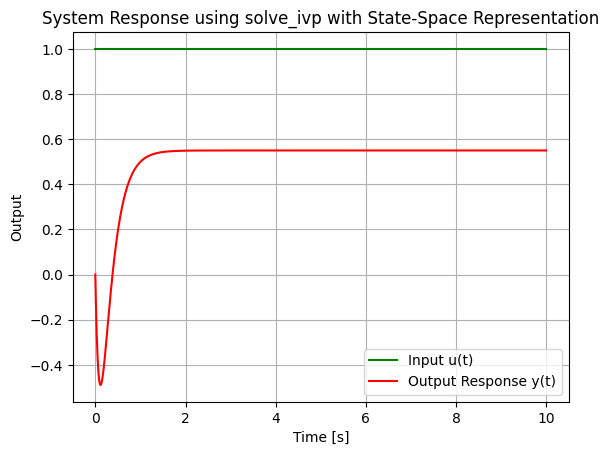

In [5]:
# Plotting the results
plt.plot(solution.t, step_input(solution.t), label='Input u(t)', color="g")
plt.plot(solution.t, y_out.T, label='Output Response y(t)', color="r")
plt.title('System Response using solve_ivp with State-Space Representation')
plt.xlabel('Time [s]')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()

## P controller

$$
\begin{equation}
u(t) = p e(t) = p (w(t) - y(t))
\end{equation}
$$

In [6]:
def desired_output(t): # input w(t)
    return np.where(t >= 2, 0.5, 0) + np.where(t >= 5, 0.25, 0)

def simulate_p(t, x, A, B, C, D, p):
    #e = desired_output(t) - C @ x
    #u = p * e
    #dxdt = A.dot(x) + B[:, 0] * u
    dxdt = (A-B @ C * p).dot(x) + B[:, 0] * desired_output(t)
    return dxdt


In [7]:
p = 0.65

# Solve the system using solve_ivp
solution = integrate.solve_ivp(simulate_p, t_span, x0, max_step=0.01, args=(A,B,C,D,p))

# Compute the output y(t) = Cx(t) + Du(t) for each time step
y_out = C.dot(solution.y)

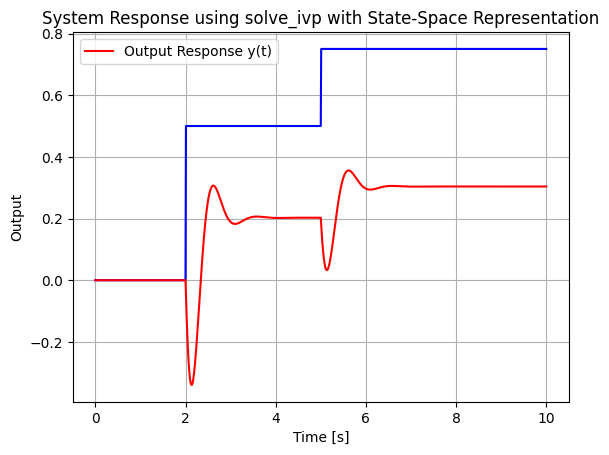

In [8]:
# Plotting the results
plt.plot(solution.t, desired_output(solution.t), color="b")
plt.plot(solution.t, y_out.T, label='Output Response y(t)', color="r")
plt.title('System Response using solve_ivp with State-Space Representation')
plt.xlabel('Time [s]')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()

## PI Controller

$$
\begin{equation}
u(t) = k_p e(t) + k_i \int_{0}^{t} e(\tau)d\tau
\end{equation}
$$
As a transfer function, using Laplace
$$
\begin{align}
U(s)s = k_p s E(s) + k_i E(s) \\
U(s) = \frac{k_p s + k_i}{s}E(s)
\end{align}
$$



In [9]:
kp = 0.8
ki = 1.5

numerator_controller = [kp, ki]
denominator_controller = [1, 0]

# Convert transfer function to state-space representation
Ac, Bc, Cc, Dc = tf2ss(numerator_controller, denominator_controller)

In [10]:
Ac, Bc, Cc, Dc

(array([[-0.]]), array([[1.]]), array([[1.5]]), array([[0.8]]))

In [11]:
Api = np.block([
    [A-B @ Dc @ C, B @ Cc],
    [-Bc @ C, Ac],
])
Bpi = np.block([
    [B @ Dc],
    [Bc],
])
Cpi = np.block([[C - D @ Dc @ C, D @ Cc]])
Dpi = D@Dc 

In [12]:
def simulate_pi(t, x, Api, Bpi, Cpi, Dpi):
    dxdt = Api.dot(x) + Bpi[:, 0] * desired_output(t)
    return dxdt

In [13]:
# Initial conditions for the state variables (zero initial condition)
x0 = np.zeros(Api.shape[0])

# Solve the system using solve_ivp
solution = integrate.solve_ivp(simulate_pi, t_span, x0, max_step=0.01, args=(Api,Bpi,Cpi,Dpi))

# Compute the output y(t) = Cpi [x(t) xc(t)] + Dpi w(t) for each time step
y_out = Cpi.dot(solution.y) + Dpi * desired_output(solution.t)

# Compute controller output u(t) = w(t) for each time step
u_out = np.block([[-Dc @ C, Cc]]) @ solution.y + Dc * desired_output(solution.t)


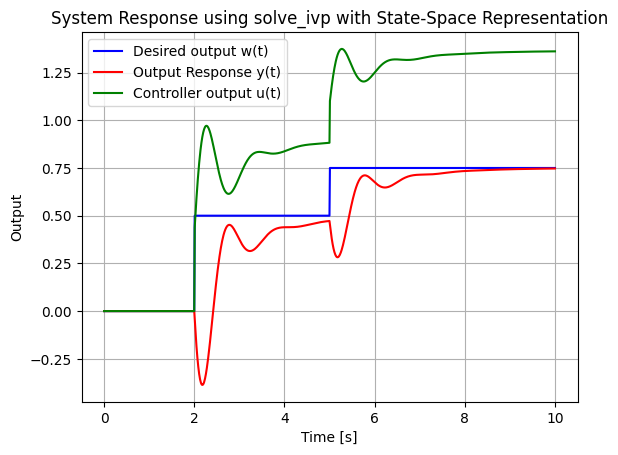

In [14]:
# Plotting the results
plt.plot(solution.t, desired_output(solution.t), label="Desired output w(t)", color="b")
plt.plot(solution.t, y_out.T, label='Output Response y(t)', color="r")
plt.plot(solution.t, u_out.T, label="Controller output u(t)", color="g")
plt.title('System Response using solve_ivp with State-Space Representation')
plt.xlabel('Time [s]')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()